In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Image
import seaborn as sns
import statistics
import math
import pickle 

In [2]:
alpha_values = np.logspace(-4, 1, 100)
alpha_values

array([1.00000000e-04, 1.12332403e-04, 1.26185688e-04, 1.41747416e-04,
       1.59228279e-04, 1.78864953e-04, 2.00923300e-04, 2.25701972e-04,
       2.53536449e-04, 2.84803587e-04, 3.19926714e-04, 3.59381366e-04,
       4.03701726e-04, 4.53487851e-04, 5.09413801e-04, 5.72236766e-04,
       6.42807312e-04, 7.22080902e-04, 8.11130831e-04, 9.11162756e-04,
       1.02353102e-03, 1.14975700e-03, 1.29154967e-03, 1.45082878e-03,
       1.62975083e-03, 1.83073828e-03, 2.05651231e-03, 2.31012970e-03,
       2.59502421e-03, 2.91505306e-03, 3.27454916e-03, 3.67837977e-03,
       4.13201240e-03, 4.64158883e-03, 5.21400829e-03, 5.85702082e-03,
       6.57933225e-03, 7.39072203e-03, 8.30217568e-03, 9.32603347e-03,
       1.04761575e-02, 1.17681195e-02, 1.32194115e-02, 1.48496826e-02,
       1.66810054e-02, 1.87381742e-02, 2.10490414e-02, 2.36448941e-02,
       2.65608778e-02, 2.98364724e-02, 3.35160265e-02, 3.76493581e-02,
       4.22924287e-02, 4.75081016e-02, 5.33669923e-02, 5.99484250e-02,
      

In [14]:
sigma_mut_final = 0.00005
sigma_mat_final = 0.5

In [15]:
def run_simulation(n_gen=1000, population_size=1000, gamma=1, sp=1,
                   sigma_mut=sigma_mut_final, sigma_mat=sigma_mat_final, sigma_alpha=0.001):
    # Setup states and transition probs
    states = ["Dry", "Wet"]
    Transition_probs = np.array([
        [sp, 1 - sp],
        [1 - sp, sp]
    ])

    Env = np.array([-0.2, 8])

    # Initialize population
    alpha = np.random.uniform(0, 1, population_size)
    epsilon_m = np.random.normal(0, sigma_mut, population_size)
    epsilon_p = np.random.normal(0, sigma_mat, population_size)
    epsilon_alpha = np.random.normal(0, sigma_alpha, population_size)

    z_a_t = np.random.uniform(0.1, 0.1, population_size)
    P = np.random.uniform(-10, 10, population_size)

    # Initialize environment state
    current_state = np.random.choice([0, 1], p=Transition_probs[0])
    current_env = Env[current_state]

    # Define z_dist and w functions (placeholders - replace with your actual functions)
    def z_dist(P, env):
        # Your transformation function here
        return P  # example placeholder

    def w(P_com):
        # Your fitness function here
        # Example: fitness decreases with squared distance from env optimum
        return np.exp(-0.1 * (P_com - current_env) ** 2)

    # Initial phenotype transformation
    P_com = z_dist(P, current_env)
    fitness = w(P_com)
    relative_fitness = fitness / fitness.mean()

    df = pd.DataFrame({
        'gen': z_a_t,
        'Phenotype': P,
        'alpha': alpha,
        'fitness': fitness,
        'relative_fitness': relative_fitness
    })

    # Sample next generation
    sampled_df = df.sample(n=population_size, weights=df['relative_fitness'], replace=True)

    z_a_t = sampled_df['gen'].values
    P = sampled_df['Phenotype'].values
    alpha = sampled_df['alpha'].values

    delta = P - z_a_t
    z_a_t_mut = z_a_t + epsilon_m
    delta_error = gamma * delta + epsilon_p
    alpha_error = alpha + epsilon_alpha

    P = (1 - alpha_error) * z_a_t_mut + alpha_error * delta_error

    for t in range(1, n_gen + 1):
        current_state = np.random.choice([0, 1], p=Transition_probs[current_state])
        current_env = Env[current_state]

        P_com = z_dist(P, current_env)
        fitness = w(P_com)
        relative_fitness = fitness / fitness.mean()

        df = pd.DataFrame({
            'gen_plus_mut': z_a_t_mut,
            'Phenotype': P,
            'maternal_deviation_werror': delta_error,
            'alpha_w_error': alpha_error,
            'fitness': fitness,
            'relative_fitness': relative_fitness
        })

        sampled_df = df.sample(n=population_size, weights=df['relative_fitness'], replace=True)

        z_a_t_mut = sampled_df['gen_plus_mut'].values
        P = sampled_df['Phenotype'].values
        alpha_error = sampled_df['alpha_w_error'].values

        epsilon_m = np.random.normal(0, sigma_mut, population_size)
        epsilon_p = np.random.normal(0, sigma_mat, population_size)
        epsilon_alpha = np.random.normal(0, sigma_alpha, population_size)

        delta = P - z_a_t_mut
        z_a_t_mut = z_a_t_mut + epsilon_m
        delta_error = gamma * delta + epsilon_p
        alpha_error = alpha_error + epsilon_alpha
        alpha_error = np.clip(alpha_error, 0, 1)

        P = (1 - alpha_error) * z_a_t_mut + alpha_error * delta_error

    # Return final mean alpha
    return np.mean(alpha_error)



In [16]:
# Run simulation 1000 times and collect results
n_simulations = 1000
final_mean_alphas = [run_simulation() for _ in range(n_simulations)]



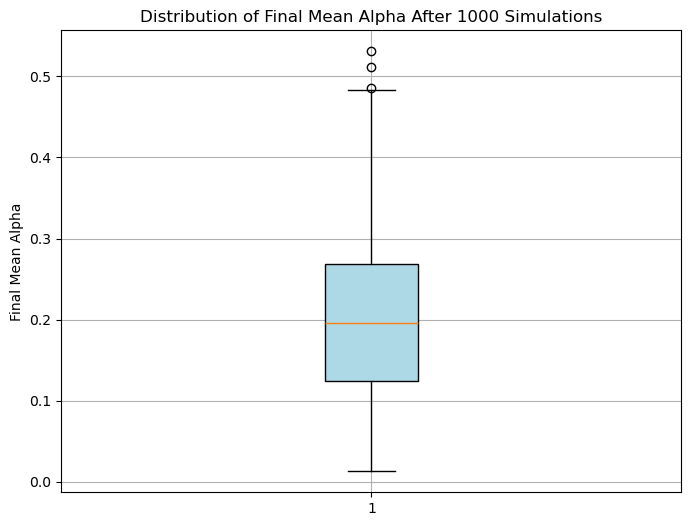

In [17]:
# Plot boxplot
plt.figure(figsize=(8, 6))
plt.boxplot(final_mean_alphas, patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.title('Distribution of Final Mean Alpha After 1000 Simulations')
plt.ylabel('Final Mean Alpha')
plt.grid(True)
plt.show()